# Training a Brain Dynamics Model

@[Chaoming Wang](https://github.com/chaoming0625)

In recent years, we saw the revolution that training a dynamical system from data or tasks has provided important insights to understand brain functions. To support this, BrainPy provides various interfaces to help users train dynamical systems.

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

bm.enable_x64()

bm.set_platform('cpu')

In [2]:
bp.__version__

'2.3.8'

In [3]:
import matplotlib.pyplot as plt

## Training a reservoir network model

For an echo state network, we have three components: an input node ("I"), a reservoir node ("R") for dimension expansion, and an output node ("O") for linear readout.

(Gauthier, et. al., Nature Communications, 2021) has proposed a next generation reservoir computing (NG-RC) model by using nonlinear vector autoregression (NVAR).

The difference between the two models is illustrated in the following figure.

![](../_static/NG-RC-vs-Traditional-RC.png)

<p align="center"> <b>(A)</b> A traditional RC processes time-series data using an artificial recurrent neural network. <b>(B)</b> The NG-RC performs a forecast using a linear weight of time-delay states of the time series data and nonlinear functionals of this data.</p>

Here, let's implement a next generation reservoir model to predict the chaotic time series, named as Lorenz attractor. Particularly, we expect the network has the ability to predict $P(t+l)$ from $P(t)$, where $l$ is the length of the prediction ahead.

In [4]:
dt = 0.01
data = bd.chaos.LorenzEq(100, dt=dt)

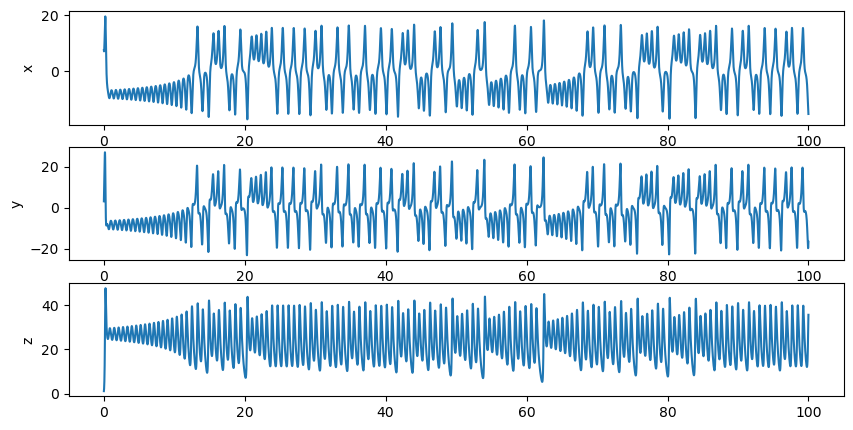

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.xs.flatten()))
plt.ylabel('x')
plt.subplot(312)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.ys.flatten()))
plt.ylabel('y')
plt.subplot(313)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.zs.flatten()))
plt.ylabel('z')
plt.show()

Let's first create a function to get the data.

In [6]:
def get_subset(data, start, end):
    res = {'x': data.xs[start: end],
           'y': data.ys[start: end],
           'z': data.zs[start: end]}
    res = bm.hstack([res['x'], res['y'], res['z']])
    return res.reshape((1, ) + res.shape)


To accomplish this task, we implement a next-generation reservoir model of 4 delay history information with stride of 5, and their quadratic polynomial monomials, same as (Gauthier, et. al., Nature Communications, 2021).

In [7]:
class NGRC(bp.DynamicalSystem):
  def __init__(self, num_in, num_out):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=4, order=2, stride=5)
    self.o = bp.layers.Dense(self.r.num_out, num_out, mode=bm.training_mode)

  def update(self, sha, x):
    # "sha" is the arguments shared across all nodes.
    # other arguments like "x" can be customized by users.
    return self.o(sha, self.r(sha, x))

In [8]:
with bm.environment(bm.batching_mode):
    model = NGRC(num_in=3, num_out=3)

Moreover, we use Ridge Regression method to train the model.

In [9]:
trainer = bp.RidgeTrainer(model, alpha=1e-6)

We warm-up the network with 20 ms.

In [10]:
warmup_data = get_subset(data, 0, int(20/dt))

outs = trainer.predict(warmup_data)

# outputs should be an array with the shape of
# (num_batch, num_time, num_out)
outs.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 2000, 3)

The training data is the time series from 20 ms to 80 ms. We want the network has the ability to forecast 1 time step ahead.

In [11]:
x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+1, int(80/dt)+1)

_ = trainer.fit([x_train, y_train])

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Then we test the trained network with the next 20 ms.

In [12]:
x_test = get_subset(data, int(80/dt), int(100/dt)-1)
y_test = get_subset(data, int(80/dt) + 1, int(100/dt))

predictions = trainer.predict(x_test)

bp.losses.mean_squared_error(y_test, predictions)

  0%|          | 0/1999 [00:00<?, ?it/s]

Array(5.36414848e-10, dtype=float64)

In [13]:
def plot_difference(truths, predictions):
    truths = bm.as_numpy(truths)
    predictions = bm.as_numpy(predictions)

    plt.subplot(311)
    plt.plot(truths[0, :, 0], label='Ground Truth')
    plt.plot(predictions[0, :, 0], label='Prediction')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(312)
    plt.plot(truths[0, :, 1], label='Ground Truth')
    plt.plot(predictions[0, :, 1], label='Prediction')
    plt.ylabel('y')
    plt.legend()
    plt.subplot(313)
    plt.plot(truths[0, :, 2], label='Ground Truth')
    plt.plot(predictions[0, :, 2], label='Prediction')
    plt.ylabel('z')
    plt.legend()
    plt.show()

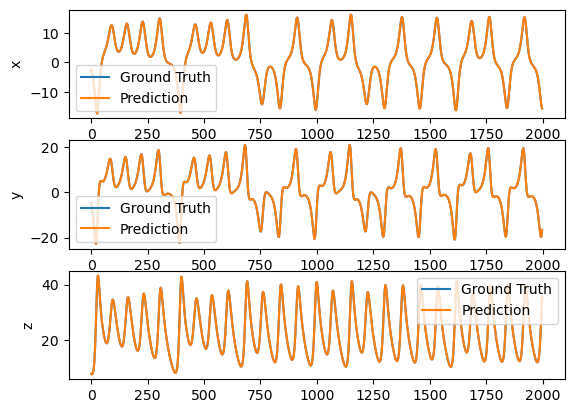

In [14]:
plot_difference(y_test, predictions)

We can make the task harder to forecast 10 time step ahead.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1990 [00:00<?, ?it/s]

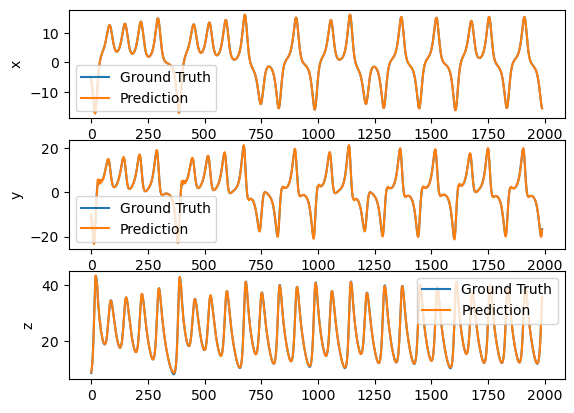

In [15]:
warmup_data = get_subset(data, 0, int(20/dt))
outs = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+10, int(80/dt)+10)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-10)
y_test = get_subset(data, int(80/dt) + 10, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

Or forecast 100 time step ahead.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

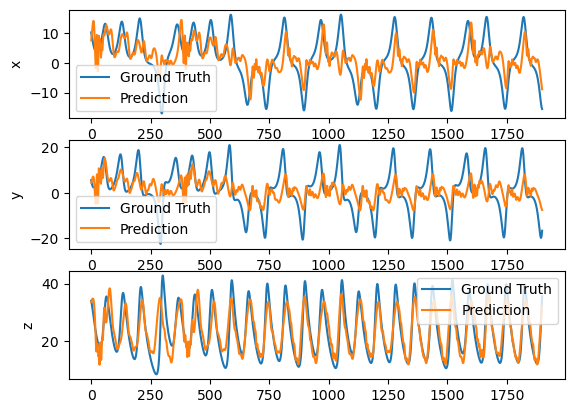

In [16]:
warmup_data = get_subset(data, 0, int(20/dt))
_ = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+100, int(80/dt)+100)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-100)
y_test = get_subset(data, int(80/dt) + 100, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

As you see, forecasting larger time step makes the learning more difficult.

## Training an artificial recurrent network

In recent years, artificial recurrent neural networks trained with back propagation through time (BPTT) have been a useful tool to study the network mechanism of brain functions. To support training networks with BPTT, BrainPy provides ``brainpy.train.BPTT`` interface.

Here, we demonstrate how to train an artificial recurrent neural network by using a white noise integration task. In this task, we want our trained RNN model has the ability to integrate white noise. For example, if we have a time series of noise data,

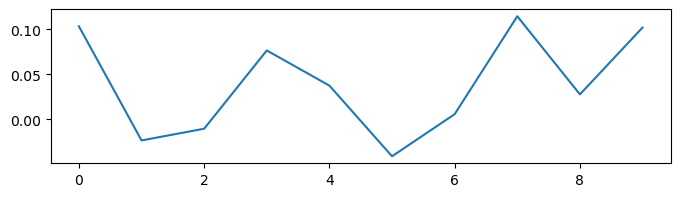

In [17]:
noises = bm.random.normal(0, 0.2, size=10)

plt.figure(figsize=(8, 2))
plt.plot(noises.to_numpy().flatten())
plt.show()

Now, we want to get a model which can integrate the noise ``bm.cumsum(noises) * dt``: 

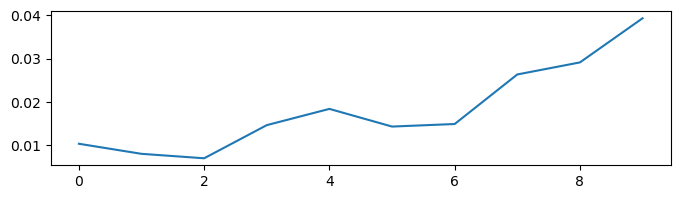

In [18]:
dt = 0.1
integrals = bm.cumsum(noises) * dt

plt.figure(figsize=(8, 2))
plt.plot(integrals.to_numpy().flatten())
plt.show()

Here, we first define a task which generates the input data and the target integration results. 

In [19]:
from functools import partial

dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128


@bm.jit
@bm.to_object(dyn_vars=bm.random.DEFAULT)
def build_inputs_and_targets(mean=0.025, scale=0.01):
  # Create the white noise input
  sample = bm.random.normal(size=(num_batch, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_batch, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets


def train_data():
  for _ in range(100):
    yield build_inputs_and_targets()

Then, we create and initialize the model. Note here we need the model train its initial state, so we need set ``state_trainable=True`` for the used `VanillaRNN` instance. 

In [20]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, sha, x):
    # "sha" is the arguments shared across all nodes.
    return self.out(sha, self.rnn(sha, x))


with bm.training_environment():
    model = RNN(1, 100)

``brainpy.nn.BPTT`` trainer receives a ``loss`` function setting, and an ``optimizer`` setting. Loss function can be selected from the ``brainpy.losses`` module, or it can be a callable function receives `(predictions, targets)` argument. Optimizer setting must be an instance of ``brainpy.optim.Optimizer``. 

Here we define a loss function which use Mean Squared Error (MSE) to measure the error between the targets and the predictions. We also apply a L2 regularization. 

In [21]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
    mse = bp.losses.mean_squared_error(predictions, targets)
    l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
    return mse + l2

In [22]:
# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)

In [23]:
# create a trainer
trainer = bp.BPTT(model,
                 loss_fun=loss,
                 optimizer=opt)

In [24]:
# train the model
trainer.fit(train_data, num_epoch=30)

Train 0 epoch, use 2.2865 s, loss 0.3474464803593203
Train 1 epoch, use 0.9384 s, loss 0.026605883508514516
Train 2 epoch, use 0.9478 s, loss 0.021708405535614907
Train 3 epoch, use 0.9892 s, loss 0.02143528795935897
Train 4 epoch, use 0.9300 s, loss 0.02107475878707875
Train 5 epoch, use 0.9298 s, loss 0.020932997073748006
Train 6 epoch, use 0.9566 s, loss 0.020855205349191275
Train 7 epoch, use 0.9072 s, loss 0.020789264013002805
Train 8 epoch, use 0.9631 s, loss 0.02066686516861348
Train 9 epoch, use 0.8968 s, loss 0.020621776997250745
Train 10 epoch, use 0.9438 s, loss 0.020569378459587808
Train 11 epoch, use 0.8785 s, loss 0.02049849876797083
Train 12 epoch, use 0.8515 s, loss 0.02047079743844964
Train 13 epoch, use 0.8533 s, loss 0.02039058010677752
Train 14 epoch, use 0.9209 s, loss 0.02035540442302181
Train 15 epoch, use 0.9844 s, loss 0.0203037559193207
Train 16 epoch, use 1.0006 s, loss 0.02025348558545429
Train 17 epoch, use 0.9397 s, loss 0.020213293431676486
Train 18 epoch

The training losses can be retrieved by `.get_hist_metric()` function. 

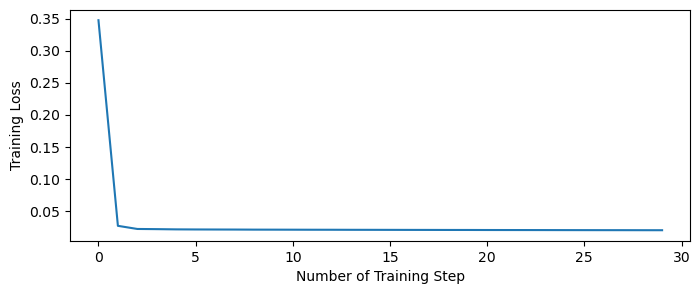

In [25]:
plt.figure(figsize=(8, 3))
plt.plot(trainer.get_hist_metric(metric='loss'))
plt.xlabel('Number of Training Step')
plt.ylabel('Training Loss')
plt.show()

Finally, let's try the trained network, and test whether it can generate the correct integration results.

In [26]:
model.reset_state(num_batch)
x, y = build_inputs_and_targets()
predicts = trainer.predict(x)

  0%|          | 0/25 [00:00<?, ?it/s]

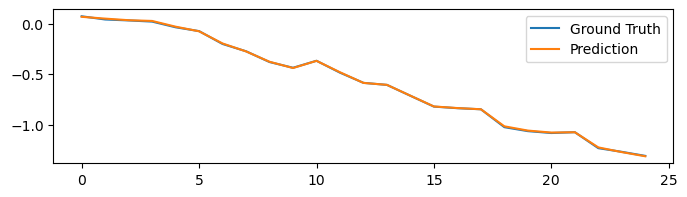

In [27]:
plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()

## Training a spiking neural network

BrainPy also supports to train spiking neural networks.

In the following, we demonstrate how to use back-propagation algorithms to train spiking neurons with a simple example.

Our model is a simple three layer model:

- an input layer
- a LIF layer
- a readout layer

The synaptic connection between each layer is the Exponenetial synapse model.

In [28]:
class SNN(bp.Network):
  def __init__(self, num_in, num_rec, num_out):
    super(SNN, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(), tau=10.,
                                       output=bp.synouts.CUBA(target_var=None),
                                       g_max=bp.init.KaimingNormal(scale=20.))
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(), tau=10.,
                                       output=bp.synouts.CUBA(target_var=None),
                                       g_max=bp.init.KaimingNormal(scale=20.))

    # whole model
    self.model = bp.Sequential(self.i, self.i2r, self.r, self.r2o, self.o)

  def update(self, tdi, spike):
    self.model(tdi, spike)
    return self.o.V.value

In [29]:
with bm.training_environment():
    net = SNN(100, 10, 2)  # out task is a two label classification task

We try to use this simple task to classify a random spiking data into two classes.

In [30]:
num_step = 2000
num_sample = 256
freq = 5  # Hz
mask = bm.random.rand(num_sample, num_step, net.num_in)
x_data = bm.zeros((num_sample, num_step, net.num_in))
x_data[mask < freq * bm.get_dt() / 1000.] = 1.0
y_data = bm.asarray(bm.random.rand(num_sample) < 0.5, dtype=bm.float_)

def get_data():
    for _ in range(1):
        yield x_data, y_data

Same as the training of artificial recurrent neural networks, we use Adam optimizer and cross entropy loss to train the model.

In [31]:
opt = bp.optim.Adam(lr=2e-3)

def loss(predicts, targets):
  return bp.losses.cross_entropy_loss(bm.max(predicts, axis=1), targets)


trainer = bp.BPTT(net,
                  loss_fun=loss,
                  optimizer=opt)

In [32]:
trainer.fit(train_data=get_data,
            num_report=10,
            num_epoch=200)

Train 10 steps, use 0.5471 s, loss 0.8119578839372008
Train 20 steps, use 0.5587 s, loss 0.7544552171954115
Train 30 steps, use 0.5898 s, loss 0.7020412181865148
Train 40 steps, use 0.5782 s, loss 0.6750034517542842
Train 50 steps, use 0.5996 s, loss 0.6638762207402613
Train 60 steps, use 0.5469 s, loss 0.6457876645959164
Train 70 steps, use 0.5286 s, loss 0.625173858852444
Train 80 steps, use 0.5480 s, loss 0.6108308776234428
Train 90 steps, use 0.5672 s, loss 0.5928884702255813
Train 100 steps, use 0.5597 s, loss 0.5864131114195933
Train 110 steps, use 0.5726 s, loss 0.5829393663656248
Train 120 steps, use 0.5730 s, loss 0.5648404392129361
Train 130 steps, use 0.5711 s, loss 0.5471623937603349
Train 140 steps, use 0.5665 s, loss 0.5335702569949301
Train 150 steps, use 0.5618 s, loss 0.5198388588329248
Train 160 steps, use 0.5529 s, loss 0.5154762874039034
Train 170 steps, use 0.5734 s, loss 0.49874691621484557
Train 180 steps, use 0.5523 s, loss 0.4925224810657929
Train 190 steps, us

The training loss is continuously decreasing, demonstrating that the network is effectively training.

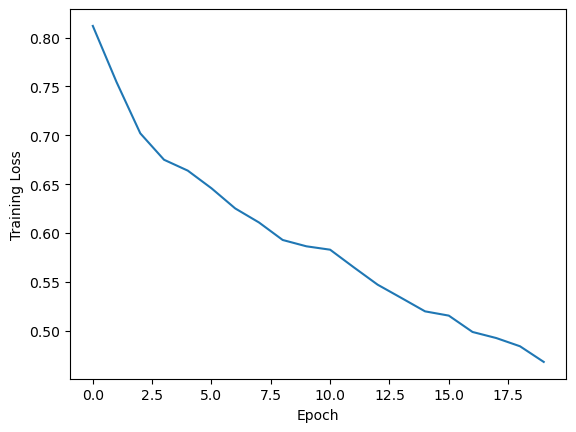

In [33]:
# visualize the training losses
plt.plot(trainer.get_hist_metric())
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

Let's visualize the trained spiking neurons.

In [34]:
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
  plt.figure(figsize=(15, 8))
  gs = GridSpec(*dim)
  mem = 1. * mem
  if spk is not None:
    mem[spk > 0.0] = spike_height
  mem = bm.as_numpy(mem)
  for i in range(np.prod(dim)):
    if i == 0:
      a0 = ax = plt.subplot(gs[i])
    else:
      ax = plt.subplot(gs[i], sharey=a0)
    ax.plot(mem[i])
  plt.tight_layout()
  plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

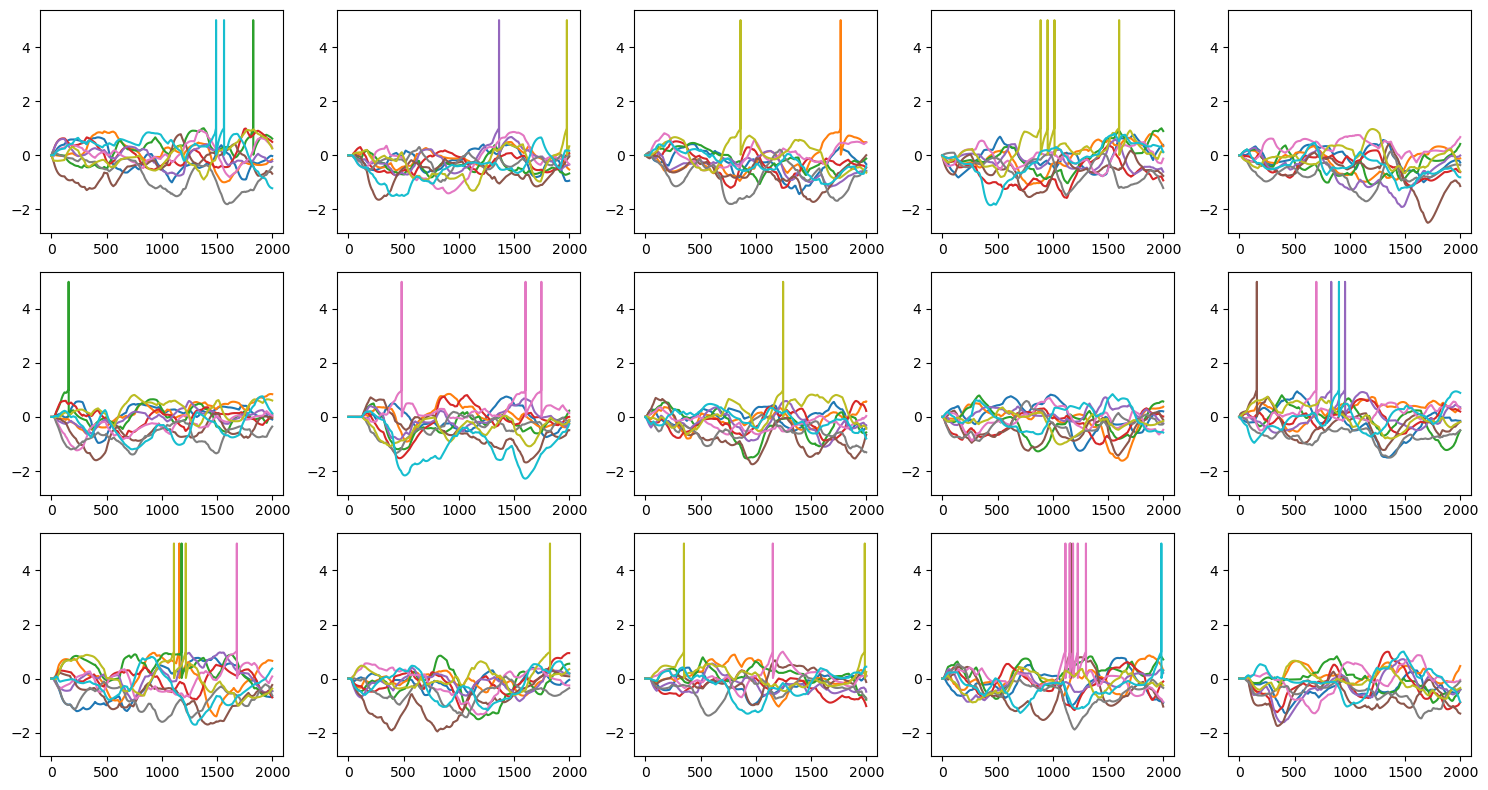

In [35]:
# get the prediction results and neural activity

runner = bp.DSRunner(
    net, monitors={'r.spike': net.r.spike, 'r.membrane': net.r.V}
)
out = runner.run(inputs=x_data, reset_state=True)
plot_voltage_traces(runner.mon.get('r.membrane'), runner.mon.get('r.spike'))

In [36]:
# the prediction accuracy

m = bm.max(out, axis=1)  # max over time
am = bm.argmax(m, axis=1)  # argmax over output units
acc = bm.mean(y_data == am)  # compare to labels
print("Accuracy %.3f" % acc)

Accuracy 0.672
